In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

# 读取数据（假设最后一列为功率值）
df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0).iloc[:-24, 7:-4]  # 排除最后24行
target = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv',header=0).iloc[-24:, 7:-4]  # 最后24行作为目标


预测性能评估：
- 平均绝对误差 (MAE): 2.7122 MW
- 均方根误差 (RMSE): 3.0310 MW
- 平均绝对百分比误差 (MAPE): 264.81%


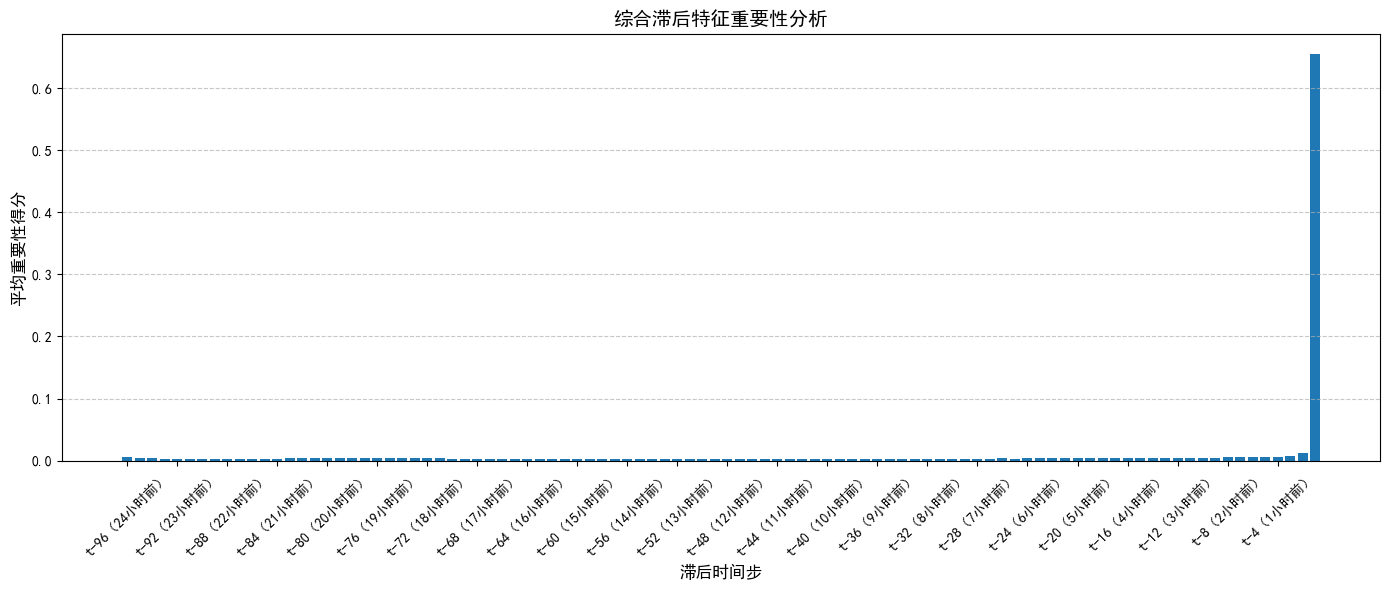

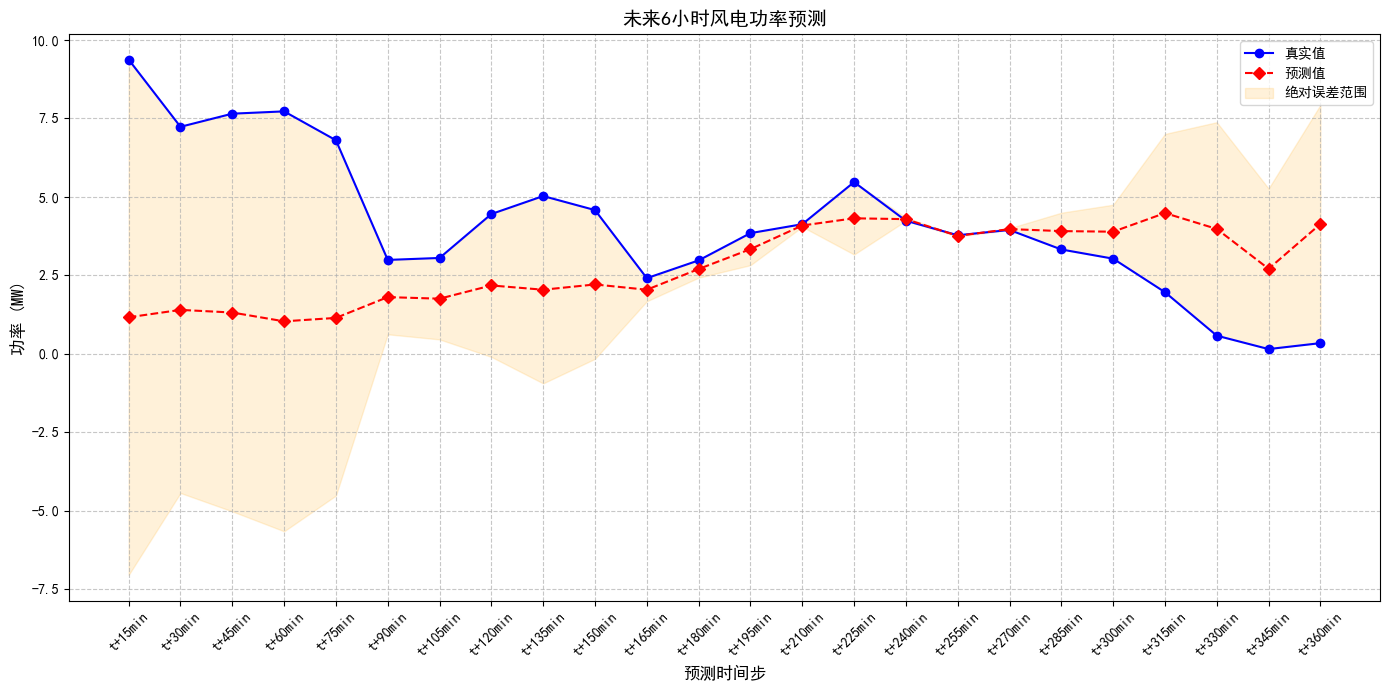

In [17]:

# 参数配置
n_lag = 24 * 4  # 使用过去24小时数据（24小时*4=96个15分钟间隔）
n_ahead = 24    # 预测未来6小时（24个15分钟间隔）
test_size = 24 * 7  # 使用最后7天数据作为测试集（保留数据连续性）

# 数据预处理
def prepare_data(data, n_lag, n_ahead):
    """
    创建时序数据集
    :param data: 包含特征和目标的全量DataFrame
    :return: (特征数组, 目标数组)
    """
    features = data.drop(columns=['Power (MW)']).values
    target = data['Power (MW)'].values.reshape(-1, 1)
    
    # 特征标准化
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # 创建时序数据集
    X, y = [], []
    for i in range(len(data)-n_lag-n_ahead):
        X.append(scaled_features[i:i+n_lag])
        y.append(target[i+n_lag:i+n_lag+n_ahead].flatten())
    return np.array(X), np.array(y), scaler

# 数据准备
X, y, feature_scaler = prepare_data(df, n_lag, n_ahead)

# 划分训练测试集（保持时间序列结构）
train_size = len(X) - test_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 模型配置
model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    )
)

# 训练模型（展平时间维度）
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 预测测试集
y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

# 评估函数
def evaluate_forecast(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    }
    return metrics

# 获取最后一个预测序列（未来6小时）
last_sequence = X_test[-1].reshape(1, -1)
final_pred = model.predict(last_sequence)[0]

# 可视化预测结果
def plot_power_forecast(true_values, predicted_values):
    plt.figure(figsize=(14, 7))
    time_steps = [f"t+{(i+1)*15}min" for i in range(len(true_values))]
    
    plt.plot(time_steps, true_values, 'bo-', label='真实值')
    plt.plot(time_steps, predicted_values, 'rD--', label='预测值')
    
    # 添加误差阴影
    error = np.abs(true_values - predicted_values)
    plt.fill_between(time_steps, 
                    predicted_values - error, 
                    predicted_values + error,
                    alpha=0.15, color='orange', label='绝对误差范围')
    
    plt.title('未来6小时风电功率预测', fontsize=14)
    plt.xlabel('预测时间步', fontsize=12)
    plt.ylabel('功率 (MW)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 获取真实值和预测值（最后24个时间步）
true_values = y_test[-1]
predicted_values = final_pred

# 性能评估
metrics = evaluate_forecast(true_values, predicted_values)
print("预测性能评估：")
print(f"- 平均绝对误差 (MAE): {metrics['MAE']:.4f} MW")
print(f"- 均方根误差 (RMSE): {metrics['RMSE']:.4f} MW")
print(f"- 平均绝对百分比误差 (MAPE): {metrics['MAPE']:.2f}%")

# 绘制特征重要性（综合所有预测器）
def plot_combined_feature_importance(model, feature_names, n_lag):
    importance_matrix = np.array([est.feature_importances_ for est in model.estimators_])
    avg_importance = importance_matrix.mean(axis=0)
    
    # 重构特征重要性矩阵
    feature_importance = avg_importance.reshape(n_lag, len(feature_names))
    summed_importance = feature_importance.sum(axis=1)
    
    plt.figure(figsize=(14, 6))
    plt.bar(range(n_lag), summed_importance)
    plt.title('综合滞后特征重要性分析', fontsize=14)
    plt.xlabel('滞后时间步', fontsize=12)
    plt.ylabel('平均重要性得分', fontsize=12)
    plt.xticks(ticks=range(0, n_lag, 4), 
              labels=[f"t-{n_lag-i}（{(n_lag-i)*15//60}小时前）" 
                      for i in range(0, n_lag, 4)],
              rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 获取特征名称（排除目标列）
feature_names = df.columns.drop('Power (MW)').tolist()

# 绘制综合特征重要性
plot_combined_feature_importance(model, feature_names, n_lag)

# 实际预测应用
def forecast_next_6h(model, last_known_data, feature_scaler, n_lag):
    """
    实际预测函数
    :param last_known_data: 最后n_lag个时间步的原始数据（DataFrame）
    :return: 预测结果数组
    """
    # 处理输入数据
    features = last_known_data.drop(columns=['Power (MW)']).values
    scaled_features = feature_scaler.transform(features)
    
    # 生成预测
    prediction = model.predict(scaled_features.flatten().reshape(1, -1))
    return prediction[0]

# 示例使用最后96个时间步数据进行预测
last_96_steps = df.iloc[-n_lag:]
next_6h_forecast = forecast_next_6h(model, last_96_steps, feature_scaler, n_lag)

# 可视化最终预测
plot_power_forecast(true_values, next_6h_forecast)